In [6]:
from Bio.PDB import PDBParser
import numpy as np
import gudhi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from Bio.PDB.MMCIFParser import MMCIFParser
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix

def create_df(structure):
    '''creates python data frame of data from .pdb files of 3D protein structures'''
    structure_list = []
    for model in structure: 
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        "Model": model.id,
                        "Chain": chain.id,
                        "Residue_Name": residue.get_resname(),
                        "Residue_ID": residue.get_id()[1],  # Sequence number
                        "Atom_Name": atom.get_name(),
                        "Element": atom.element,
                        "X": atom.coord[0],
                        "Y": atom.coord[1],
                        "Z": atom.coord[2]
                    }
                    structure_list.append(atom_info)
    df = pd.DataFrame(structure_list)
    return df

def create_residue_point_cloud(df):
    '''takes in dataframe of .pdb info and creates residue point cloud'''
    # we only want to keep amino acids, no water molecules
    amino_acids = {'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 
               'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 
               'THR', 'TRP', 'TYR', 'VAL'}
    protein_residues = df[df['Residue_Name'].isin(amino_acids)]
    return protein_residues.groupby(["Residue_ID", "Chain"])[['X', 'Y', 'Z']].mean()[['X', 'Y', 'Z']].to_numpy()

def create_3d_plot(point_cloud):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = point_cloud[:, 0]
    y = point_cloud[:, 1]
    z = point_cloud[:, 2]

    sc = ax.scatter(x, y, z, c='dodgerblue', s=20, alpha=0.7)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point Cloud of Hemoglobin Structure')

    plt.tight_layout()
    plt.show()
    return

def make_rips_simplextree_diagram(point_cloud): # can probably add it here
    max_edge_length = 25
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    diagram = simplex_tree.persistence()
    return rips_complex, simplex_tree, diagram

def significant_features(diagram, min_persistence=0.5):
    '''finds significant features of the plot'''
    significant_features = [(dim, (birth, death)) for dim, (birth, death) in diagram if (death - birth) >= min_persistence]
    return significant_features

def plot(diagram):
    gudhi.plot_persistence_diagram(diagram)
    gudhi.plot_persistence_barcode(diagram)
    return

In [7]:
# deoxygenated hemiglobin data
parser2 = PDBParser(QUIET=True)
deoxy = parser2.get_structure("deoxy", "data/1a3n.pdb") # deoxy
deoxy_df = create_df(deoxy)
deoxy_point_cloud = deoxy_df[['X', 'Y', 'Z']].to_numpy()
deoxy_residue_point_cloud = create_residue_point_cloud(deoxy_df)

# oxygenated hemoglobin data
parser3 = MMCIFParser(QUIET=True)
oxy = parser3.get_structure("oxy1", "data/1hho-assembly1.cif")
oxy_df = create_df(oxy)
oxy1_df = oxy_df[oxy_df["Residue_Name"] != "OXY"] # remove oxygens from point cloud
oxy_point_cloud = oxy_df[['X', 'Y', 'Z']].to_numpy()
oxy_residue_point_cloud = create_residue_point_cloud(oxy1_df)

# sicklecell; carbon monoxide bound at all four spots
parser1 = PDBParser(QUIET=True)
sicklecell = parser1.get_structure("sicklecell", "data/5e83.pdb")
sicklecell_df = create_df(sicklecell)
sicklecell_point_cloud = sicklecell_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
sicklecell_residue_point_cloud = create_residue_point_cloud(sicklecell_df)

# carbon monoxide bound at all four spots
parser1 = PDBParser(QUIET=True)
co = parser1.get_structure("co_bound", "data/6hal.pdb")
co_df = create_df(co)
co_point_cloud = co_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
co_residue_point_cloud = create_residue_point_cloud(co_df)

# deoxyhemoglobin with bpg bound and sphingosine phosphate (?) -- there are four of them
parser1 = PDBParser(QUIET=True)
deoxybpg = parser1.get_structure("deoxybpg", "data/5ksi.pdb")
deoxybpg_df = create_df(deoxybpg)
deoxybpg_point_cloud = deoxybpg_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
deoxybpg_residue_point_cloud = create_residue_point_cloud(deoxybpg_df)

# Wild-type Fetal Human Hemoglobin HbF (two carbon monoxides bound?)
# I do not know what is going on here, so no fetal. s
parser1 = PDBParser(QUIET=True)
fetal = parser1.get_structure("fetal", "data/4mqj.pdb")
fetal_df = create_df(fetal)

# carbon monoxide bound antisickling agent 5-methoxy-2-(pyridin-2-ylmethoxy)benzaldehyde
parser1 = PDBParser(QUIET=True)
antisickle = parser1.get_structure("antisickle", "data/6bnr.pdb")
antisickle_df = create_df(antisickle)
antisickle_point_cloud = antisickle_df[['X', 'Y', 'Z']].to_numpy() # create point cloud (extract 3 dim coordinates)
antisickle_residue_point_cloud = create_residue_point_cloud(antisickle_df)

In [ ]:
# create everything
deoxy_rips_complex, deoxy_simplex_tree, deoxy_diagram = make_rips_simplextree_diagram(deoxy_residue_point_cloud)
oxy_rips_complex, oxy_simplex_tree, oxy_diagram = make_rips_simplextree_diagram(oxy_residue_point_cloud)
sicklecell_rips_complex, sicklecell_simplex_tree, sicklecell_diagram = make_rips_simplextree_diagram(sicklecell_residue_point_cloud)
co_rips_complex, co_simplex_tree, co_diagram = make_rips_simplextree_diagram(co_residue_point_cloud)
deoxybpg_rips_complex, deoxybpg_simplex_tree, deoxybpg_diagram = make_rips_simplextree_diagram(deoxybpg_residue_point_cloud)
antisickle_rips_complex, antisickle_simplex_tree, antisickle_diagram = make_rips_simplextree_diagram(antisickle_residue_point_cloud)

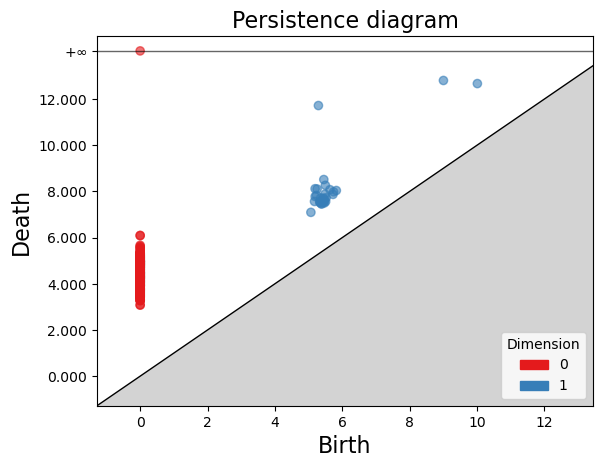

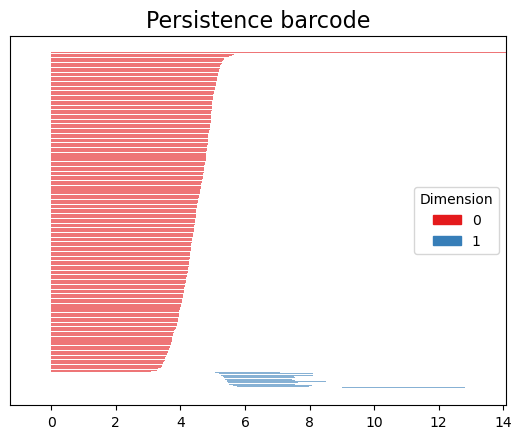

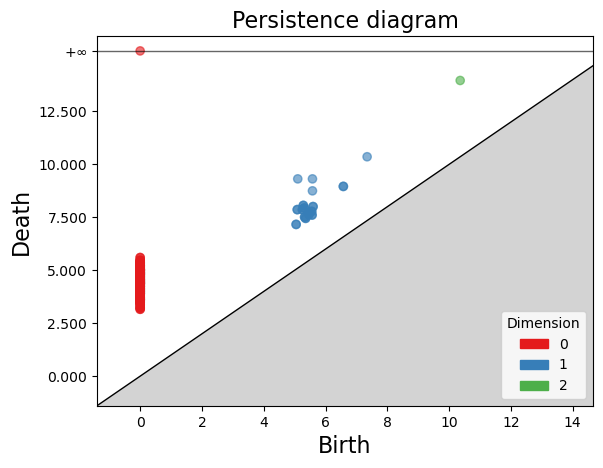

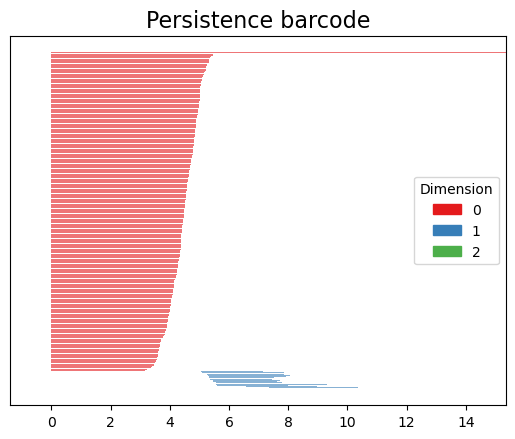

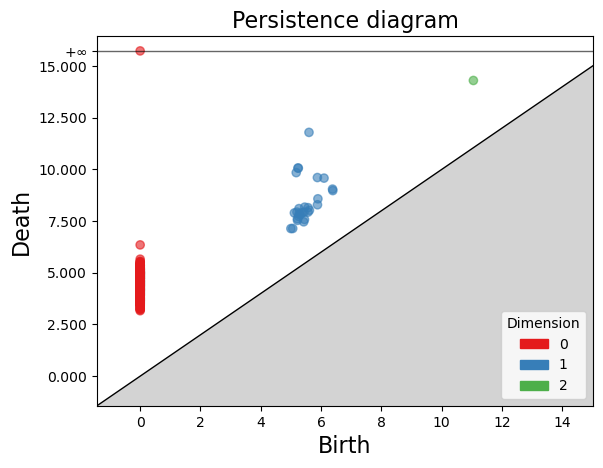

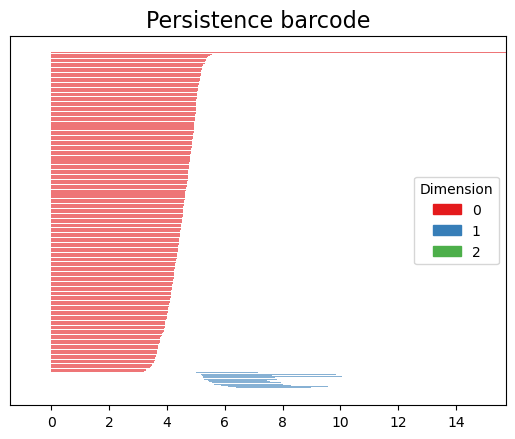

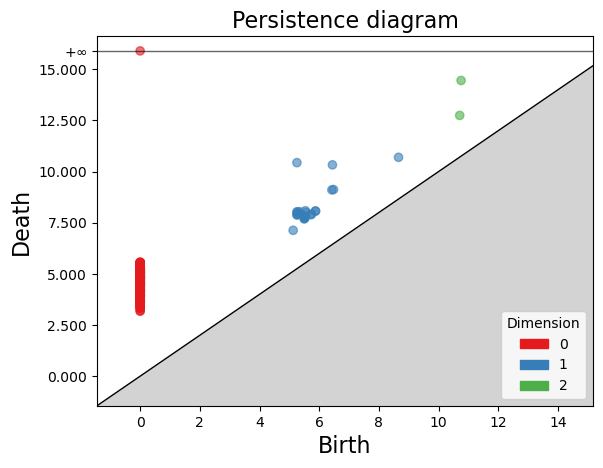

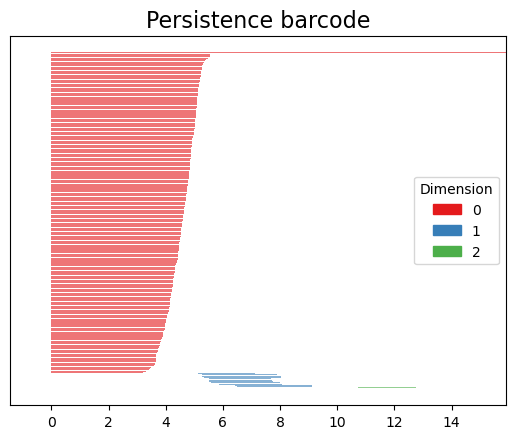

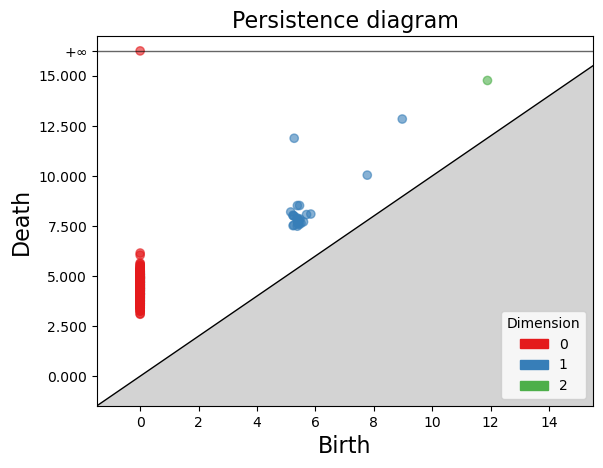

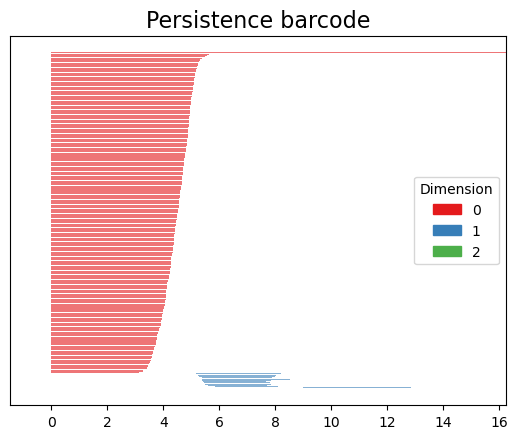

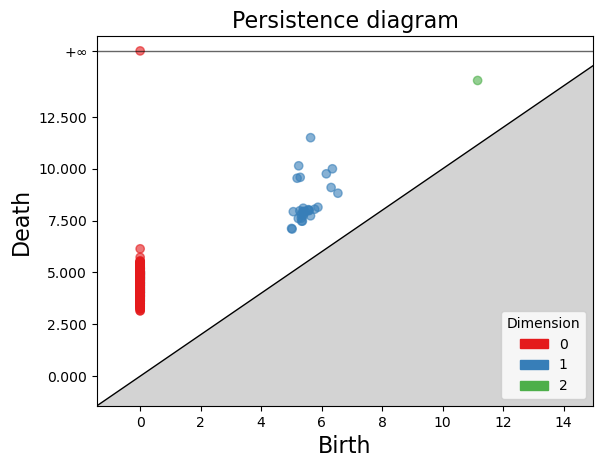

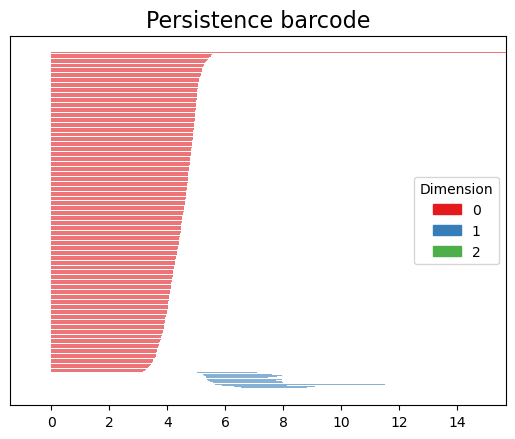

In [ ]:
# pull out significant features + plot
deoxy_significant_features = significant_features(deoxy_diagram)
plot(deoxy_significant_features)
oxy_significant_features = significant_features(oxy_diagram)
plot(oxy_significant_features)
sicklecell_significant_features = significant_features(sicklecell_diagram)
plot(sicklecell_significant_features)
co_significant_features = significant_features(co_diagram)
plot(co_significant_features)
deoxybpg_significant_features = significant_features(deoxybpg_diagram)
plot(deoxybpg_significant_features)
antisickle_significant_features = significant_features(antisickle_diagram)
plot(antisickle_significant_features)

In [ ]:
def bottleneck_distances(d1, d2, p=False, d1_name="", d2_name=""):
    distances = []
    for i in range(3):
        d1_pairs = np.array([pair for dim, pair in d1 if dim == i])
        d2_pairs = np.array([pair for dim, pair in d2 if dim == i])
        # get rid of inf values
        d1_noinf = d1_pairs[~np.isinf(d1_pairs).any(axis=1)]
        d2_noinf = d2_pairs[~np.isinf(d2_pairs).any(axis=1)]
        distances.append(gudhi.bottleneck_distance(d1_noinf, d2_noinf))
    if p == True:
        print(f"Bottleneck distances between {d1_name} and {d2_name}:")
        for i in range(3):
            print(f"\tDimension {i}:", distances[i])
    return distances

# want to compare oxygenated hemiglobin and sicklecell hemi because CO bound to sites on sicklecell, O2 bound on oxy sites
bottleneck_wt_sicklecell = bottleneck_distances(co_diagram, sicklecell_diagram, p=True, d1_name="WT (co bound)", d2_name="sicklecell (co bound)")
bottleneck_sickle_deoxy = bottleneck_distances(deoxy_diagram, oxy_diagram, p=True, d1_name="deoxy", d2_name="oxy")
bottleneck_sickle_deoxy = bottleneck_distances(deoxy_diagram, deoxybpg_diagram, p=True, d1_name="deoxy", d2_name="deoxy (bpg bound)")
bottleneck_wt_sicklecell = bottleneck_distances(antisickle_diagram, sicklecell_diagram, p=True, d1_name="antisickle (co bound)", d2_name="sicklecell (co bound)")
bottleneck_wt_sicklecell = bottleneck_distances(antisickle_diagram, co_diagram, p=True, d1_name="antisickle (co bound)", d2_name="WT (co bound)")

Bottleneck distances between WT (co bound) and sicklecell (co bound):
	Dimension 0: 1.6454977253814316
	Dimension 1: 1.4932611774241131
	Dimension 2: 0.6373994024974561
Bottleneck distances between deoxy and oxy:
	Dimension 0: 1.5793137623325875
	Dimension 1: 2.0516150866079537
	Dimension 2: 1.5253611722365683
Bottleneck distances between deoxy and deoxy (bpg bound):
	Dimension 0: 1.5591220321986772
	Dimension 1: 1.1316357448874461
	Dimension 2: 0.5435493985247106
Bottleneck distances between antisickle (co bound) and sicklecell (co bound):
	Dimension 0: 0.20797099904060357
	Dimension 1: 0.4727287818429957
	Dimension 2: 0.5818939329806732
Bottleneck distances between antisickle (co bound) and WT (co bound):
	Dimension 0: 1.6361190051222811
	Dimension 1: 1.4587396432365516
	Dimension 2: 0.6607421257317405


In [6]:
import scipy.stats as stats
def t_test_between_diagrams(d1, d2, d1_name='', d2_name='', dim=2):
    print(f"T-test Stats for {d1_name} and {d2_name}")
    for i in range(dim+1):
        # diagram 1
        d1_birth = [v[1][0] for v in d1 if v[0] == i]
        d1_death = [v[1][1] for v in d1 if v[0] == i]

        # diagram 2
        d2_birth = [v[1][0] for v in d2 if v[0] == i]
        d2_death = [v[1][1] for v in d2 if v[0] == i]
        
        if i==0: # getting rid of inf value the lazy way
            d2_death = d2_death[1:]
            d1_death = d1_death[1:]

        birth_test = stats.ttest_ind(d1_birth, d2_birth)
        death_test = stats.ttest_ind(d1_death, d2_death)

        print(f"For dim={i}:")
        print(f"\t birth: {birth_test}")
        print(f"\t death: {death_test}")

    print()
    return
t_test_between_diagrams(oxy_diagram, deoxy_diagram, d1_name="oxy", d2_name="deoxy")
t_test_between_diagrams(co_diagram, sicklecell_diagram, d1_name="oxy", d2_name="sickle")
t_test_between_diagrams(deoxy_diagram, deoxybpg_diagram, d1_name="deoxy", d2_name="deoxy (bpg bound)")

T-test Stats for oxy and deoxy
For dim=0:
	 birth: TtestResult(statistic=nan, pvalue=nan, df=1144.0)
	 death: TtestResult(statistic=-0.24532871253094413, pvalue=0.8062459998913556, df=1142.0)
For dim=1:
	 birth: TtestResult(statistic=-0.9364302883489329, pvalue=0.34931275086399427, df=866.0)
	 death: TtestResult(statistic=-0.248543625645049, pvalue=0.8037727477289897, df=866.0)
For dim=2:
	 birth: TtestResult(statistic=0.6641770458325589, pvalue=0.5076616622711555, df=141.0)
	 death: TtestResult(statistic=1.0131910622804368, pvalue=0.31270438588465116, df=141.0)

T-test Stats for oxy and sickle
For dim=0:
	 birth: TtestResult(statistic=nan, pvalue=nan, df=1140.0)
	 death: TtestResult(statistic=2.1305521549878965, pvalue=0.03334000447582092, df=1138.0)
For dim=1:
	 birth: TtestResult(statistic=1.9991094172714354, pvalue=0.04588964116720159, df=922.0)
	 death: TtestResult(statistic=1.2091858599325942, pvalue=0.2269014254603251, df=922.0)
For dim=2:
	 birth: TtestResult(statistic=0.857148

In [7]:
import scipy.stats as stats
def t_test_within_diagram(d1, d1_name='', dim=2):
    print(f"T-test Stats for {d1_name}")
    for i in range(dim+1):
        # diagram 1
        d1_birth = [v[1][0] for v in d1 if v[0] == i]
        d1_death = [v[1][1] for v in d1 if v[0] == i]

        if i==0: # getting rid of inf value the lazy way
            d1_birth = d1_birth[1:]
            d1_death = d1_death[1:]

        test = stats.ttest_rel(d1_birth, d1_death)

        print(f"\tFor dim={i}: {test}")

    print()
    return
t_test_within_diagram(oxy_diagram, d1_name="oxy")
t_test_within_diagram(deoxy_diagram, d1_name="de")
t_test_within_diagram(sicklecell_diagram, d1_name="sickle")


T-test Stats for oxy
	For dim=0: TtestResult(statistic=-215.65060774783595, pvalue=0.0, df=572)
	For dim=1: TtestResult(statistic=-23.586116124702194, pvalue=1.206707328042694e-78, df=415)
	For dim=2: TtestResult(statistic=-10.013859257048495, pvalue=6.062440531579352e-15, df=67)

T-test Stats for de
	For dim=0: TtestResult(statistic=-205.3249083901709, pvalue=0.0, df=570)
	For dim=1: TtestResult(statistic=-23.507287011189177, pvalue=2.33893961044945e-80, df=451)
	For dim=2: TtestResult(statistic=-10.812862016801317, pvalue=6.902935158679237e-17, df=74)

T-test Stats for sickle
	For dim=0: TtestResult(statistic=-213.03360872237508, pvalue=0.0, df=572)
	For dim=1: TtestResult(statistic=-21.032227591897424, pvalue=4.203220815621414e-69, df=455)
	For dim=2: TtestResult(statistic=-9.754083206573547, pvalue=5.548711253421882e-15, df=75)

